## 导入必要的库

In [3]:
%matplotlib inline

import math
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

## 计算数据集的熵

In [4]:
'''
parameter:
    dataset: numpy array
    index: the feature to split the dataset
'''
def calculate_entropy(dataset, index=-1):
    data = dataset[:, index].tolist()
    data_counter = Counter(data)
    
    entropy = 0
    N = len(dataset)
    for k, v in data_counter.items():
        pk = float(v)/N
        entropy += -pk*math.log2(pk)
    
    return entropy

In [5]:
dataset_list = [
    [1, 1, 'yes'],
    [1, 1, 'yes'],
    [1, 0, 'no'],
    [0, 1, 'no'],
    [0, 1, 'no']
]
labels = ['no surface', 'Flippers']

dataset = np.array(dataset_list)
print(calculate_entropy(dataset))

0.9709505944546686


## 以某一个特征对数据集进行分割

In [6]:
'''
parameter:
    dataset: dataset
    axis: index of axis
    value: split point's value
'''
def split_dataset(dataset, axis, value):
    ret_data_set=[]
    axis_data = dataset[:, axis]
    ret_data_set = dataset[axis_data==value, :]
    ret_data_set = np.delete(ret_data_set, axis, 1)
    return ret_data_set

In [7]:
feature_axis = 1
feature_set = np.unique(dataset[:, feature_axis])
for feature in feature_set:
    print(split_dataset(dataset, feature_axis, feature))

[['1' 'no']]
[['1' 'yes']
 ['1' 'yes']
 ['0' 'no']
 ['0' 'no']]


## 选择最好的划分特征进行数据集的划分

1. 遍历所有的特征
2. 对于每一个特征，拿到该特征可取的所有值
3. 对该值和特征进行数据集的划分，得到划分之后的子集
4. 对于子集，计算条件熵和信息增益
5. 选择信息增益最大的特征进行数据集的划分

In [8]:
'''
parameter:
    dataset: dataset
'''
def choose_best_feature_to_split(dataset):
    ''' calculate H(D) '''
    HD = calculate_entropy(dataset)
    
    best_feature_axis = 0
    best_entropy_gain = -np.inf
    ''' choose best feature '''
    N = dataset.shape[1]-1
    for feat_axis in range(N):
        feature_set = np.unique(dataset[:, feat_axis])
        condition_entropy = 0
        ''' each split value '''
        for feature in feature_set:
            sub_feature_set = split_dataset(dataset, feature_axis, feature)
            pk = sub_feature_set.shape[0]/(N+1)
            condition_entropy += pk*calculate_entropy(sub_feature_set)
        entropy_gain = HD - condition_entropy
        if entropy_gain > best_entropy_gain:
            best_entropy_gain = entropy_gain
            best_feature_axis = feat_axis
    return best_feature_axis

In [9]:
best_feature_axis = choose_best_feature_to_split(dataset)
print(best_feature_axis)

0


In [10]:
feature_set = np.unique(dataset[:, best_feature_axis])
for feature in feature_set:
    print(split_dataset(dataset, best_feature_axis, feature))

[['1' 'no']
 ['1' 'no']]
[['1' 'yes']
 ['1' 'yes']
 ['0' 'no']]


## 递归的创建决策树

递归函数的描述:
1. 终止条件：数据集中仅有一个类了或者没有特征再进行细分
2. 不满足终止条件的话，继续选择最优的特征，之后按照最优特征分出子集，对子集进行递归

In [11]:
'''
choose the major class in dataset
class_list: numpy type
'''
def major_class(class_list):
    counter = Counter(class_list.tolist())
    main_class = -1
    main_num = -np.inf
    for k, v in counter.items():
        if v > main_num:
            main_num = v
            main_class = k
    return main_class

In [12]:
'''
create dtree in a recursive way
parameter:
    dataset: dataset
    labels: labels of the features
'''
def create_dtree(dataset, labels):
    class_list = dataset[:,-1]
    ''' check terminal conditions '''
    ''' if only one class in the dataset '''
    if np.alltrue(class_list==class_list[0]):
        return class_list[0]
    ''' if there is no feature can be split '''
    if len(dataset[0]) == 1:
        return major_class(class_list)
    
    ''' choose best feature to split dataset '''
    feat_axis = choose_best_feature_to_split(dataset)
    feat_label = labels[feat_axis]
    # inner node of tree
    tree_node = {feat_label: {}}
    # get the all value feature can use
    feature_set = np.unique(dataset[:, feat_axis])
    # make sub_label: remove this feature's label
    sub_label = labels[:feat_axis] + labels[feat_axis+1:]
    for feature in feature_set:
        sub_dataset = split_dataset(dataset, feat_axis, feature)
        tree_node[feat_label][str(feature)] = create_dtree(sub_dataset, sub_label)
    return tree_node

In [13]:
dtree = create_dtree(dataset, labels)
print(dtree)

{'no surface': {'0': 'no', '1': {'Flippers': {'0': 'no', '1': 'yes'}}}}


## 测试数据

在得到决策树之后，我们需要编写测试函数对我们生成的决策树进行测试，算法描述如下：
1. 获取到输入的特征向量test_data和每个特征的名称test_labels
2. 解析树的当前节点，获取该节点的label名称和取值values，随后到test_labels中找到index
3. 在test_data中取出该label的值，在values找到对应值后的规则
4. 如果后面的规则为一个类，那么返回该类，如果不是类（又是一个树结点），返回到2中，直到找到对应的类

In [14]:
'''
test function
parameter:
    tree_root: DTree's root node
    test_features: test feature vector
    test_labels: test feature's labels
'''
def test_dtree(tree_root, test_features, test_labels):
    feat_label = list(tree_root.keys())[0]
    feat_value = tree_root[feat_label]
    idx = test_labels.index(feat_label)
    for v in feat_value:
        # remember transform the number type to string
        if v != str(test_features[idx]):
            continue
        if isinstance(feat_value[v], dict):
            return test_dtree(feat_value[v], test_features, test_labels)
        else:
            return feat_value[v]

In [15]:
print("decision tree: \n", dtree)
print("test data: [0, 1], result is ", test_dtree(dtree, [0, 1], ['no surface', 'Flippers']))
print("test data: [1, 0], result is ", test_dtree(dtree, [1, 0], ['no surface', 'Flippers']))
print("test data: [1, 1], result is ", test_dtree(dtree, [1, 1], ['no surface', 'Flippers']))

decision tree: 
 {'no surface': {'0': 'no', '1': {'Flippers': {'0': 'no', '1': 'yes'}}}}
test data: [0, 1], result is  no
test data: [1, 0], result is  no
test data: [1, 1], result is  yes


## 绘制决策树

In [18]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')

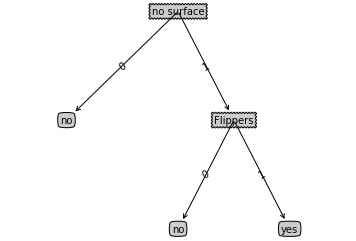

In [19]:
createPlot(dtree)